### Oil type by origin "US" (general attribution)
Goal: Determine general case of fuel allocation 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

master_dir  = '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/'
master_file = 'master.yaml'

with open(f'{master_dir}{master_file}') as file:
    master = yaml.safe_load(file)

vessel_types = master['categories']['tank_vessels']
fuel_types   = master['categories']['fuel_type']

In [3]:
vessel_types

['tanker', 'atb', 'barge']

In [4]:
# Import columns are: (G) Deliverer, (H) Receiver, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

#### Extract cargo data transferred from vessel to facility

In [5]:
# list of names in DOE dataset that are used as "DelivererTypeDescription" for vessel transfers
vessel_names = ['TANK SHIP', 'TANK BARGE', 'TUGBOAT']
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]
cargo_from_facility = cargo_data[ cargo_data['DelivererTypeDescription']=='Facility' ]
cargo_to_tank   = cargo_from_facility[ cargo_from_facility['ReceiverTypeDescription'] == 'TANK SHIP' ]
cargo_to_barge  = cargo_from_facility[ cargo_from_facility['ReceiverTypeDescription'] == 'TANK BARGE' ] 
cargo_to_tug    = cargo_from_facility[ cargo_from_facility['ReceiverTypeDescription'] == 'TUGBOAT' ]

cargo_to_facility = cargo_data[ cargo_data['ReceiverTypeDescription']=='Facility' ]
cargo_from_tank   = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TANK SHIP' ]
cargo_from_barge  = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TANK BARGE' ] 
cargo_from_tug    = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TUGBOAT' ]

cargo_tank = pd.concat([cargo_to_tank,cargo_from_tank])
cargo_barge = pd.concat([cargo_to_barge, cargo_from_barge])
cargo_tug = pd.concat([cargo_to_tug,  cargo_from_tug])

# reset indices so they increase chronologically from 0 instead of keeping parent index values
cargo_tank.reset_index( drop=True, inplace=True )
cargo_barge.reset_index( drop=True, inplace=True )
cargo_tug.reset_index( drop=True, inplace=True )

In [6]:
cargo_tank.shape

(910, 7)

In [7]:
[nrows,ncols] = cargo_barge.shape

In [8]:
# create ATB and tank barge dataframes
cargo_atb = pd.DataFrame(columns = cargo_barge.columns)
for row in range(nrows):
    if ('ITB' in cargo_barge.Receiver[row] or 'ATB' in cargo_barge.Receiver[row] or 
    'ITB' in cargo_barge.Deliverer[row] or 'ATB' in cargo_barge.Deliverer[row]):
        cargo_atb = cargo_atb.append( cargo_barge.iloc[row] )

for row in range(nrows):
    if ('ITB' in cargo_barge.Receiver[row] or 'ATB' in cargo_barge.Receiver[row] or 
    'ITB' in cargo_barge.Deliverer[row] or 'ATB' in cargo_barge.Deliverer[row]):        
        cargo_barge = cargo_barge.drop([row])

# reset indexing        
cargo_atb.reset_index( drop=True, inplace=True )

In [9]:
# concatenate tank barge dataframes
cargo_barge = pd.concat([cargo_barge, cargo_tug])

# reset indexing
cargo_barge.reset_index( drop=True, inplace=True )

### Total up the volume of fuel by fuel category for vessel types used in this study

In [10]:
# create dictionary structure
US = {}
for vessel in vessel_types:
    US[vessel]={}
    for fuel in fuel_types:
        US[vessel][fuel]={}
        US[vessel][fuel]['total_gallons']=0
        US[vessel][fuel]['number_of_transfers']=0
        US[vessel][fuel]['fraction_of_total']=0

#### Tankers

In [11]:
[nrows,ncols] = cargo_tank.shape
label = 'tanker'
for row in range(nrows):
    
    if 'CRUDE' in cargo_tank.Product[row]:
        US[label]['akns']['total_gallons'] += cargo_tank.TransferQtyInGallon[row].item()
        US[label]['akns']['number_of_transfers'] += 1

    elif cargo_tank.Product[row] == 'BUNKER OIL/HFO':
        US[label]['bunker']['total_gallons'] += cargo_tank.TransferQtyInGallon[row].item()
        US[label]['bunker']['number_of_transfers'] += 1

    elif cargo_tank.Product[row] == 'GASOLINE':
        US[label]['gas']['total_gallons'] += cargo_tank.TransferQtyInGallon[row].item()
        US[label]['gas']['number_of_transfers'] += 1

    elif cargo_tank.Product[row] == 'JET FUEL/KEROSENE':
        US[label]['jet']['total_gallons'] += cargo_tank.TransferQtyInGallon[row].item()
        US[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_tank.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        US[label]['diesel']['total_gallons'] += cargo_tank.TransferQtyInGallon[row].item()
        US[label]['diesel']['number_of_transfers'] += 1

    else:
        US[label]['other']['total_gallons'] += cargo_tank.TransferQtyInGallon[row].item()
        US[label]['other']['number_of_transfers'] += 1    

In [12]:
US[label]['other']['total_gallons']

444150477

#### ATBs

In [13]:
[nrows,ncols] = cargo_atb.shape
label = 'atb'
for row in range(nrows):
    
    if 'CRUDE' in cargo_atb.Product[row]:
        ### WHY DOES ADDING A .ITEM() HERE GIVE AN ERROR WHEN IT DOESN'T ABOVE?
        US[label]['akns']['total_gallons'] += cargo_atb.TransferQtyInGallon[row]
        US[label]['akns']['number_of_transfers'] += 1

    elif cargo_atb.Product[row] == 'BUNKER OIL/HFO':
        US[label]['bunker']['total_gallons'] += cargo_atb.TransferQtyInGallon[row]
        US[label]['bunker']['number_of_transfers'] += 1

    elif cargo_atb.Product[row] == 'GASOLINE':
        US[label]['gas']['total_gallons'] += cargo_atb.TransferQtyInGallon[row]
        US[label]['gas']['number_of_transfers'] += 1

    elif cargo_atb.Product[row] == 'JET FUEL/KEROSENE':
        US[label]['jet']['total_gallons'] += cargo_atb.TransferQtyInGallon[row]
        US[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_atb.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        US[label]['diesel']['total_gallons'] += cargo_atb.TransferQtyInGallon[row]
        US[label]['diesel']['number_of_transfers'] += 1

    else:
        US[label]['other']['total_gallons'] += cargo_atb.TransferQtyInGallon[row]
        US[label]['other']['number_of_transfers'] += 1   

In [14]:
cargo_atb.Product

0             BUNKER OIL/HFO
1      DIESEL/MARINE GAS OIL
2                   GASOLINE
3                   GASOLINE
4      DIESEL/MARINE GAS OIL
               ...          
669                 GASOLINE
670           BUNKER OIL/HFO
671                  Z-OTHER
672           BUNKER OIL/HFO
673        JET FUEL/KEROSENE
Name: Product, Length: 674, dtype: object

#### Barges

In [15]:
[nrows,ncols] = cargo_barge.shape
label = 'barge'

for row in range(nrows):
    
    if 'CRUDE' in cargo_barge.Product[row]:
        US[label]['akns']['total_gallons'] += cargo_barge.TransferQtyInGallon[row].item()
        US[label]['akns']['number_of_transfers'] += 1

    elif cargo_barge.Product[row] == 'BUNKER OIL/HFO':
        US[label]['bunker']['total_gallons'] += cargo_barge.TransferQtyInGallon[row].item()
        US[label]['bunker']['number_of_transfers'] += 1

    elif cargo_barge.Product[row] == 'GASOLINE':
        US[label]['gas']['total_gallons'] += cargo_barge.TransferQtyInGallon[row].item()
        US[label]['gas']['number_of_transfers'] += 1

    elif cargo_barge.Product[row] == 'JET FUEL/KEROSENE':
        US[label]['jet']['total_gallons'] += cargo_barge.TransferQtyInGallon[row].item()
        US[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_barge.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        US[label]['diesel']['total_gallons'] += cargo_barge.TransferQtyInGallon[row].item()
        US[label]['diesel']['number_of_transfers'] += 1

    else:
        US[label]['other']['total_gallons'] += cargo_barge.TransferQtyInGallon[row].item()
        US[label]['other']['number_of_transfers'] += 1   


#### Determine percent oil for each oil type

In [16]:
for vessel in vessel_types:

    # first get the total transfers over all fuel types
    total = sum([ US[vessel][fuel]['total_gallons'] for fuel in fuel_types ])

    for fuel in fuel_types:
  
        # next calculate percentages
        if total != 0:
            US[vessel][fuel]['fraction_of_total'] = round(
                US[vessel][fuel]['total_gallons'] / total, 
                4
            )

#  Check to make sure fraction of total sums to 1
for vessel in vessel_types:
    sum_check = [US[vessel][fuel]['fraction_of_total'] for fuel in fuel_types]
    if sum(sum_check) != 1 and sum(sum_check) != 0:
        # add oil to "other" category to fix sum to 1
        shortfall  = 1-sum(sum_check)
        US[vessel]['other']['fraction_of_total'] += shortfall
        print(f'{vessel} SHORTFALL:{shortfall} (corrected)')

        # double check
        sum_check = [US[vessel][fuel]['fraction_of_total'] for fuel in fuel_types]
        if sum(sum_check) != 1 and sum(sum_check) !=0 :
            print(f'NOT THERE YET!: {vessel}, {facility}:{sum(sum_check_out)}')

    elif sum(sum_check) != 1:
        print(f' {vessel}:{sum(sum_check_in)}')
 

atb SHORTFALL:-9.999999999998899e-05 (corrected)
barge SHORTFALL:1.1102230246251565e-16 (corrected)


In [17]:
with open(r'./US_general.yaml', 'w') as file:
    documents = yaml.safe_dump(US, file)

#### Plot results

In [18]:
fuel_types

['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']

Text(0.5, 1.0, 'tanker fuel allocation for general = US')

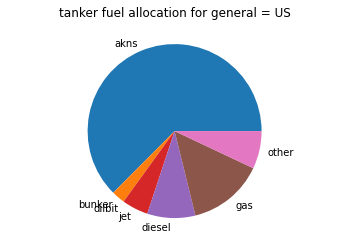

In [19]:
label = 'tanker'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for general = US')

Text(0.5, 1.0, 'atb fuel allocation for general = US')

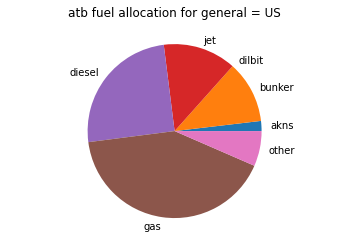

In [20]:
label = 'atb'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for general = US')

Text(0.5, 1.0, 'barge fuel allocation for general = US')

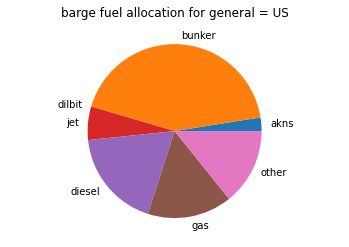

In [21]:
label = 'barge'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for general = US')

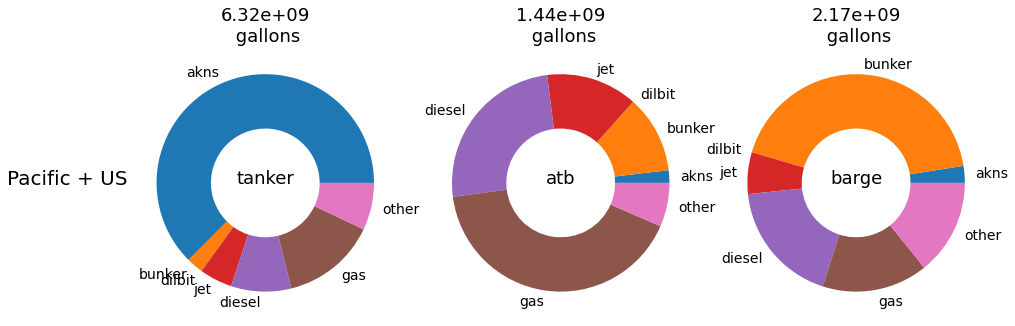

In [22]:
import matplotlib.pyplot as plt

# re-calc total transfers over all fuel types
total_tanker = sum([ US['tanker'][fuel]['total_gallons'] for fuel in fuel_types ])
total_atb    = sum([ US['atb'][fuel]['total_gallons'] for fuel in fuel_types ])
total_barge  = sum([ US['barge'][fuel]['total_gallons'] for fuel in fuel_types ])

total = [total_tanker, total_atb, total_barge]

plot_array = np.empty(len(fuel_types))

fig, axes = plt.subplots(1, len(vessel_types), figsize = (15,5))

plt.text(0, 0.5, 
         'Pacific + US ', 
         ha='left',
         fontsize=20,
         wrap=True,
         transform=plt.gcf().transFigure)

for j in range(len(vessel_types)):
    vessel = vessel_types[j]
    # create array of total fuel volume by fuel type for each vessel at each facility
    fuel_index = 0
    for fuel in fuel_types:    
        plot_array[fuel_index]=US[vessel][fuel]['total_gallons']
        fuel_index += 1

    axes[j].axis('equal')
    axes[j].set_title(f'{total[j]:4.2e}\n gallons',fontsize=18)

    if plot_array.sum()>0:
        axes[j].pie(plot_array, wedgeprops=dict(width=0.5), labels = fuel_types, textprops={'fontsize': 14})
    else:
        axes[j].axis('off')
    axes[j].text(0,0,vessel,ha='center',fontsize=18)

plt.savefig('US_combined.png')